# Credit 

- https://www.kaggle.com/itratrahman/nlp-tutorial-using-python

In [36]:

# OP 
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline
%pylab inline
import seaborn  as sns 
from matplotlib import pyplot
import matplotlib.pyplot as plt



# ML 

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['array']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# set plot style
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

## 0) Load data 

In [3]:
# help fun 

def get_sentence_length(x):
    return len(x)

def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)


# stop words : show stop words in English 


def stopwords_(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    sw = stopwords.words('english')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)


# create an object of stemming function
stemmer = SnowballStemmer("english")
def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [4]:
# LOAD THE DATA 

df = pd.read_csv('spam.csv', delimiter=',',encoding='latin-1')
df = df.loc[:,['v1','v2']]

# get feature

df['length'] = df['v2'].apply(get_sentence_length)
# remove punctuation
df['v2_del_punct'] = df['v2'].apply(remove_punctuation)
# remove stopwords
df['v2_del_stopword'] = df['v2'].apply(stopwords_)
# get stem
df['v2_stemming'] = df['v2'].apply(stemming)


df.head()

,v1,v2,length,v2_del_punct,v2_del_stopword,v2_stemming
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go until jurong point crazy Available only in ...,"go jurong point, crazy.. available bugis n gre...","go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,ok lar... joking wif u oni...,ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,free entri in 2 a wkli comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,49,U dun say so early hor U c already then say,u dun say early hor... u c already say...,u dun say so earli hor... u c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah I dont think he goes to usf he lives aroun...,"nah think goes usf, lives around though","nah i don't think he goe to usf, he live aroun..."


## 1) Data Overview

Text(0.5,1,'Sentence Length Histagram')

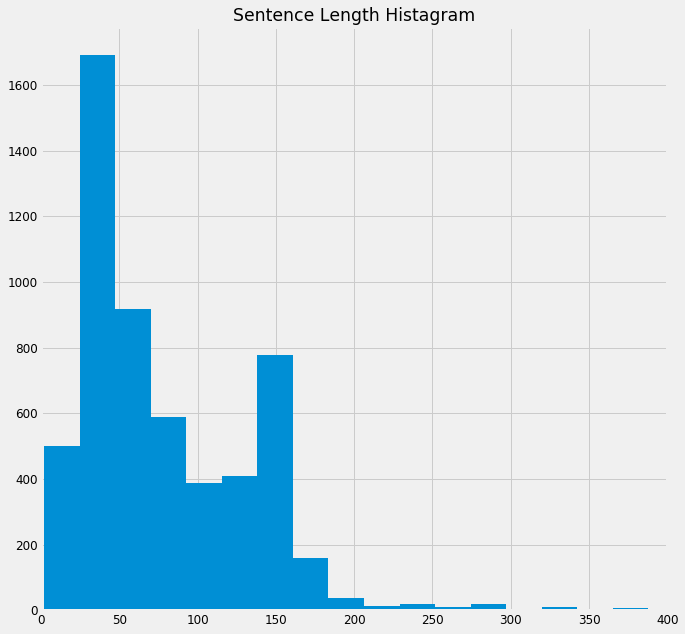

In [5]:
# sentence length hist 

df.length.hist(bins=40)
plt.xlim(0,400)
plt.title('Sentence Length Histagram')

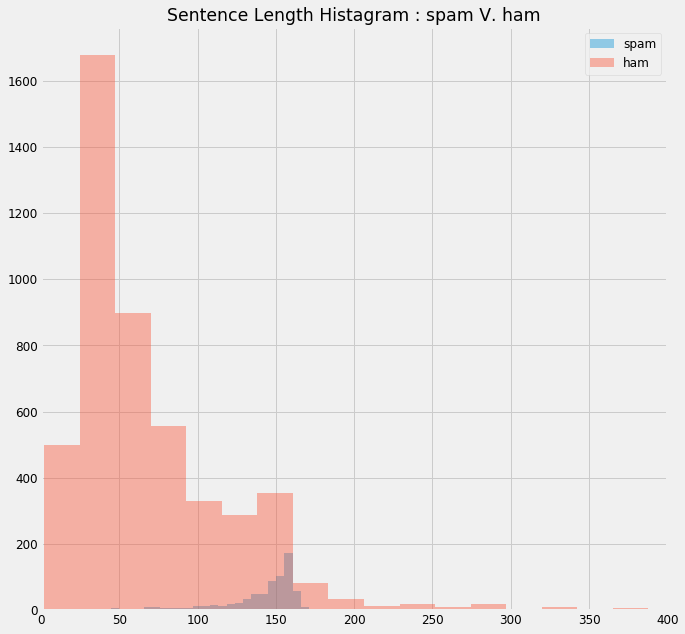

In [6]:
# sentence length hist  with spam V. ham

df[df.v1 == 'spam' ].length.hist(bins=40,alpha = 0.4)
df[df.v1 == 'ham' ].length.hist(bins=40,alpha = 0.4)
plt.xlim(0,400)
plt.title('Sentence Length Histagram : spam V. ham')
plt.legend(['spam','ham'])
plt.show()

In [7]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)

In [8]:
Y.shape

(5572,)

In [9]:
pd.DataFrame(Y)[0].value_counts()

0    4825
1     747
Name: 0, dtype: int64

In [10]:
X.iloc[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [11]:
X.iloc[1]

'Ok lar... Joking wif u oni...'

## 1) NLP feature extract 

In [12]:
stopwords

<WordListCorpusReader in '/Users/yennanliu/nltk_data/corpora/stopwords'>

In [13]:
#print("Number of stopwords: ", len(sw))

In [14]:
df.head()

,v1,v2,length,v2_del_punct,v2_del_stopword,v2_stemming
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go until jurong point crazy Available only in ...,"go jurong point, crazy.. available bugis n gre...","go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,ok lar... joking wif u oni...,ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,free entri in 2 a wkli comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,49,U dun say so early hor U c already then say,u dun say early hor... u c already say...,u dun say so earli hor... u c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah I dont think he goes to usf he lives aroun...,"nah think goes usf, lives around though","nah i don't think he goe to usf, he live aroun..."


In [15]:
# Collect vocabulary count


# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(df['v2_del_stopword'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()

# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

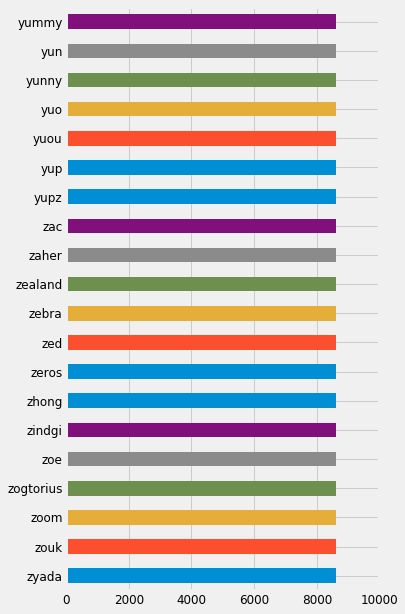

In [16]:
# plot top vacab.

top_vacab = vocab_bef_stem[20:40]
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (0, 10000))

In [17]:
# stemming ops 
# run stemming operation 

print ('stemming words :  ')
print ('-'*10)
print ('')
print (df['v2_stemming'].head(5))
print ('-'*10)
print ('original words :  ')
df['v2'].head(5)

stemming words :  
----------

0    go until jurong point, crazy.. avail onli in b...
1                          ok lar... joke wif u oni...
2    free entri in 2 a wkli comp to win fa cup fina...
3    u dun say so earli hor... u c alreadi then say...
4    nah i don't think he goe to usf, he live aroun...
Name: v2_stemming, dtype: object
----------
original words :  


0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object

ûówell     8649
ûò         8648
ûïharry    8647
ûï         8646
ûªve       8645
dtype: int64


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


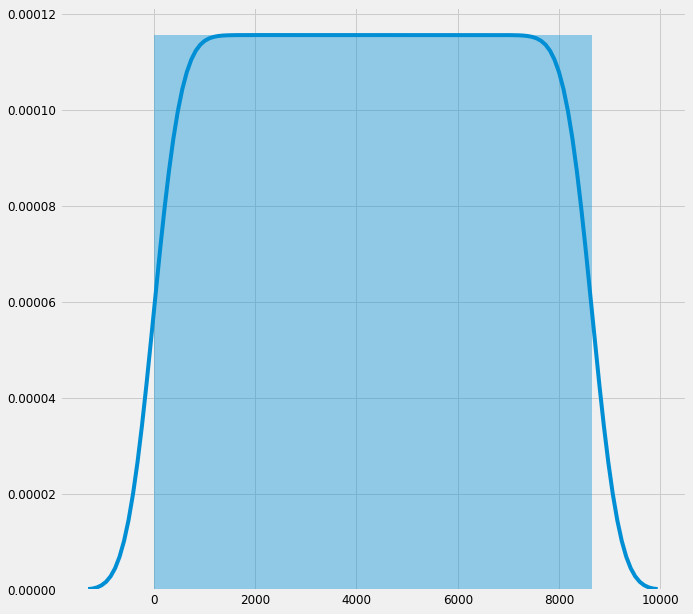

In [18]:
#  TF-IDF Extraction : I 


"""


TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

"""

# create the object of tfid vectorizer
EAP_tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
EAP_tfid_vectorizer.fit(df['v2_del_stopword'])
# collect the vocabulary items used in the vectorizer
EAP_dictionary = EAP_tfid_vectorizer.vocabulary_.items()

# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in EAP_dictionary:
    vocab.append(key)
    count.append(value)
    
# store the count in panadas dataframe with vocab as index
EAP_vocab = pd.Series(count, index=vocab)
# sort the dataframe
EAP_vocab = EAP_vocab.sort_values(ascending=False)

print (EAP_vocab.head(5))
sns.distplot(EAP_vocab)


In [19]:
#  TF-IDF Extraction : II

from sklearn.feature_extraction.text import  TfidfVectorizer


In [37]:
# create the object of tfid vectorizer
#tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
#tfid_vectorizer.fit(df['v2_stemming'])
# collect the vocabulary items used in the vectorizer
#dictionary = tfid_vectorizer.vocabulary_.items()  

In [21]:
# extract the tfid representation matrix of the text data
tfid_matrix = tfid_vectorizer.transform(df['v2_del_stopword'])
# collect the tfid matrix in numpy array
array = tfid_matrix.todense()

In [22]:
array

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [25]:
# store the tf-idf array into pandas dataframe
df_vectorize = pd.DataFrame(array)
df_vectorize.head(10)

,0,1,2,3,4,5,6,7,8,9,...,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
shape(df_vectorize)

(5572, 8182)

In [29]:
shape(array)

(5572, 8182)

In [30]:
shape(df)

(5572, 6)

In [26]:
df.head(1)

,v1,v2,length,v2_del_punct,v2_del_stopword,v2_stemming
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go until jurong point crazy Available only in ...,"go jurong point, crazy.. available bugis n gre...","go until jurong point, crazy.. avail onli in b..."


## 2) Model 

### 2-1) MultinomialNB (multinomial Naive Bayes classifier)

In [31]:
df_vectorize['v1'] = df['v1']

In [33]:
features = df_vectorize.columns.tolist()
output = 'v1'
# removing the output and the id from features
features.remove(output)

In [39]:
alpha_list1 = np.linspace(0.006, 0.1, 20)
alpha_list1 = np.around(alpha_list1, decimals=4)
alpha_list1

# parameter grid
parameter_grid = [{"alpha":alpha_list1}]

In [40]:
parameter_grid

[{'alpha': array([ 0.006 ,  0.0109,  0.0159,  0.0208,  0.0258,  0.0307,  0.0357,
          0.0406,  0.0456,  0.0505,  0.0555,  0.0604,  0.0654,  0.0703,
          0.0753,  0.0802,  0.0852,  0.0901,  0.0951,  0.1   ])}]

In [41]:
# TRAIN 

# classifier object
classifier1 = MultinomialNB()
# gridsearch object using 4 fold cross validation and neg_log_loss as scoring paramter
gridsearch1 = GridSearchCV(classifier1,parameter_grid, scoring = 'neg_log_loss', cv = 4)
# fit the gridsearch
gridsearch1.fit(df_vectorize[features], df_vectorize[output])


GridSearchCV(cv=4, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([ 0.006 ,  0.0109,  0.0159,  0.0208,  0.0258,  0.0307,  0.0357,
        0.0406,  0.0456,  0.0505,  0.0555,  0.0604,  0.0654,  0.0703,
        0.0753,  0.0802,  0.0852,  0.0901,  0.0951,  0.1   ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [42]:
results1 = pd.DataFrame()
# collect alpha list
results1['alpha'] = gridsearch1.cv_results_['param_alpha'].data
# collect test scores
results1['neglogloss'] = gridsearch1.cv_results_['mean_test_score'].data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
alpha,0.006,0.0109,0.0159,0.0208,0.0258,0.0307,0.0357,0.0406,0.0456,0.0505,0.0555,0.0604,0.0654,0.0703,0.0753,0.0802,0.0852,0.0901,0.0951,0.1
neglogloss,-0.0604415,-0.0581206,-0.0570768,-0.0565603,-0.0562909,-0.0561711,-0.0561395,-0.0561664,-0.0562339,-0.0563275,-0.056443,-0.0565706,-0.0567118,-0.0568583,-0.0570142,-0.057172,-0.0573371,-0.0575022,-0.0576735,-0.0578437


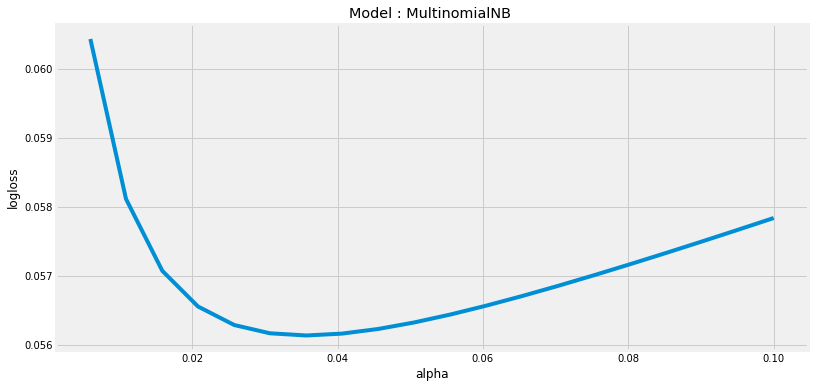

In [50]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results1['alpha'], -results1['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.title('Model : MultinomialNB ')

results1.T

In [52]:
print("Best parameter: ",gridsearch1.best_params_)
print("Best score: ",gridsearch1.best_score_) 

Best parameter:  {'alpha': 0.035700000000000003}
Best score:  -0.0561394615851


In [32]:
df_vectorize.head(1)

,0,1,2,3,4,5,6,7,8,9,...,8173,8174,8175,8176,8177,8178,8179,8180,8181,v1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ham
